### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net2Loops.inp`. Let's start by setting up the model:

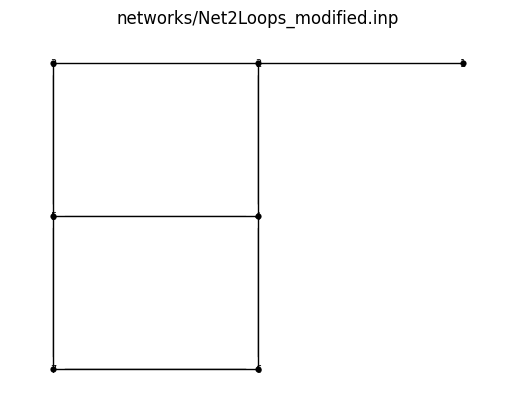

{'duration': 0.0,
 'hydraulic_timestep': 3600,
 'quality_timestep': 300,
 'rule_timestep': 360,
 'pattern_timestep': 7200,
 'pattern_start': 0.0,
 'report_timestep': 3600,
 'report_start': 0.0,
 'start_clocktime': 0.0,
 'statistic': 'NONE',
 'pattern_interpolation': False}

In [11]:
import os
from pathlib import Path
import wntr
import wntr_quantum

# Define the directory path
epanet_tmp_dir = Path("/Users/murilo/scratch_dir/.epanet_quantum")

# check if the directory exists
if not epanet_tmp_dir.exists():
    epanet_tmp_dir.mkdir(parents=True, exist_ok=True)

# set the environment variables
os.environ["EPANET_TMP"] = str(epanet_tmp_dir)
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net2Loops_modified.inp'  # reproduces the values in https://doi.org/10.3390/w14060851
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# explicitly set Darcy-Weisbach head loss formulas and pressure dependent demand mode if needed
wn.options.hydraulic.headloss = 'D-W'
wn.options.hydraulic.demand_model = 'PDD' # 'PDD'

# set up Darcy-Weisbach roughness coefficients for all pipes
for ix, ip in enumerate(wn.pipe_name_list):
    pipe = wn.get_link(ip)
    pipe.roughness = 0.85e-3

# required pressure: the pressure above which the consumer should receive the desired demand
wn.options.hydraulic.required_pressure = 30.0 # m
# minimum pressure: this is the pressure below which the consumer cannot receive any water
wn.options.hydraulic.minimum_pressure  = 5.0 # m

# set time duration of the simulation (in seconds)
wn.options.time.duration = 0

# print options
dict(wn.options.hydraulic)
dict(wn.options.time)

### Solve model using `EpanetSimulator`

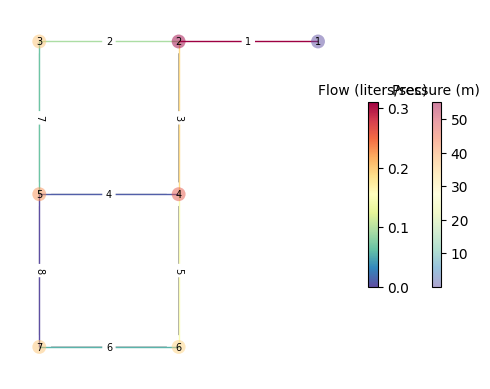

(name          2          3          4          5          6         7  \
 0     55.207382  36.046581  46.785488  41.211845  34.623741  36.07058   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2         3         4         5        6         7  \
 0     1.894879  1.850352  1.461332  1.094416  1.135989  1.09901  1.302307   
 
 name         8  
 0     0.272257  )

In [12]:
# define classical solver using EpanetSimulator 
sim = wntr.sim.EpanetSimulator(wn)

# run the classical EPANET simulation
results_original_epanet = sim.run_sim()

# plot network
wntr.graphics.plot_network(
    wn,
    node_attribute=results_original_epanet.node["pressure"].iloc[0],
    link_attribute=results_original_epanet.link["flowrate"].iloc[0],
    node_colorbar_label='Pressure (m)',
    link_colorbar_label='Flow (liters/sec)',
    node_size=100,
    node_labels=True,
    link_labels=True,
    node_alpha=0.5,
)

results_original_epanet.node["pressure"], results_original_epanet.link["velocity"]

### Solve model using the classical Cholesky solver from `QuantumEpanetSimulator`

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [13]:
# define classical solver using QuantumEpanetSimulator 
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET quantum simulation using classical Cholesky
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

# load EPANET A and b matrices from temp
epanet_A, epanet_b = wntr_quantum.sim.epanet.load_epanet_matrix()

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["velocity"]

Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/.epanet_quantum

Size of the Jacobian in EPANET simulator: 6
Size of the b vector in EPANET simulator: 6


(name          2          3         4          5          6          7  \
 0     55.207436  36.046638  46.78558  41.211903  34.623852  36.070694   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2         3         4         5         6         7  \
 0     1.894867  1.850351  1.461321  1.094419  1.135983  1.099011  1.302309   
 
 name         8  
 0     0.272237  )

### Check that the classical results are equivalent

In [16]:
import pandas.testing as pdt

pdt.assert_frame_equal(results_original_epanet.node["pressure"], results_epanet.node["pressure"])
pdt.assert_frame_equal(results_original_epanet.link["flowrate"], results_epanet.link["flowrate"])
# pdt.assert_frame_equal(results_original_epanet.link["velocity"], results_epanet.link["velocity"])

### Define a helper function

Before proceeding to the proper quantum solution of the water network model, let's define a helper function. This function checks that the quantum results are within `TOL`% of those obtained classically. It also fills in lists containing the final values of pressures and flow rates obtained.

In [17]:
TOL = 5  # => per cent
DELTA = 1.0e-12


def get_ape_from_pd_series(quantum_pd_series, classical_pd_series):
    """Helper function to evaluate absolute percentage error between classical and quantum results."""
    ape = abs(quantum_pd_series - classical_pd_series) * 100.0 / abs(classical_pd_series + DELTA)
    return ape


def compare_results(classical_result, quantum_result):
    """
    Helper function that compares the classical and quantum simulation results.
    """
    classical_data = []
    quantum_data = []

    def check_ape(classical_value, quantum_value):
        """Helper function to check if the absolute percentage error between classical and quantum results is within TOL."""
        ape = abs(quantum_value - classical_value) * 100.0 / abs(classical_value + DELTA)
        is_close_to_classical = ape <= TOL
        if is_close_to_classical:
            print(f"Quantum result {quantum_value} within {ape}% of classical result {classical_value}")
            quantum_data.append(quantum_value)
            classical_data.append(classical_value)
        return is_close_to_classical

    for link in classical_result.link["flowrate"].columns:
        classical_value = classical_result.link["flowrate"][link].iloc[0]
        quantum_value = quantum_result.link["flowrate"][link].iloc[0]
        message = f"Flowrate {link}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    for node in classical_result.node["pressure"].columns:
        classical_value = classical_result.node["pressure"][node].iloc[0]
        quantum_value = quantum_result.node["pressure"][node].iloc[0]
        message = f"Pressure {node}: {quantum_value} not within {TOL}% of classical result {classical_value}"
        assert check_ape(classical_value, quantum_value), message

    return classical_data, quantum_data

### Solve water network with `QuantumEpanetSimulator` and VQLS 

We now solve the model using VQLS. In this example, we are **preconditioning** the initial linear system using *diagonal scaling* and also using a **mix of two classical optimizers**.

In [18]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

sim = wntr_quantum.sim.QuantumEpanetSimulator(wn, linear_solver=linear_solver)
results_vqls = sim.run_sim(linear_solver=linear_solver)

results_classical, results_quantum = compare_results(results_epanet, results_vqls)

results_vqls.node["pressure"], results_vqls.link["velocity"]

VQLS Iteration 1000 Cost 6.140e-06
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 5.719744E-06    MAXCV = 0.000000E+00
   X =-6.133676E-01   2.060431E+00   4.818918E-01   3.487873E+00  -1.038291E+00
      -8.479660E-01   6.046514E-01   1.129100E+00  -1.935607E+00   3.315516E+00
       1.144954E+00  -2.634952E+00
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 390
         Gradient evaluations: 30
VQLS Iteration 1000 Cost 2.352e-02
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS = 1000   F = 2.351948E-02    MAXCV = 0.000000E+00
   X = 2.905101E+00   2.169338E+00   1.743479E+00   1.964157E+00  -1.612071E+00
      -1.549190E-01   3.083667E-01   2.318041E+00   4.147605E-01  -1.341471E+00
      -1.992533E+00   9.582821E-02
Optimization terminated successfully.
         Current function value: 0.000000
         Iter

(name          2         3          4         5          6          7  \
 0     55.205914  36.04459  46.782398  41.20937  34.619946  36.066059   
 
 name             1  
 0     4.394531e-07  ,
 name         1         2         3         4         5         6        7  \
 0     1.895196  1.850409  1.461709  1.094382  1.136192  1.099135  1.30238   
 
 name         8  
 0     0.271825  )

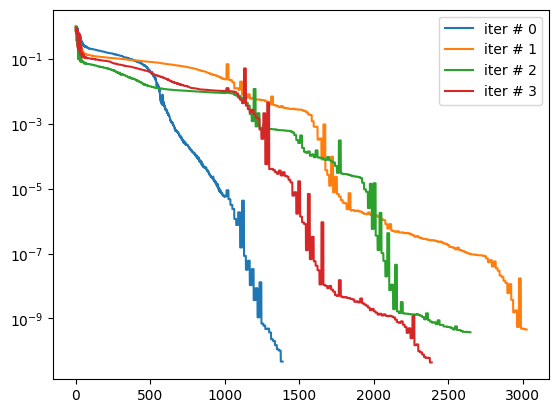

In [19]:
import matplotlib.pyplot as plt
for i, result in enumerate(results_vqls.linear_solver_results):
    plt.semilogy(result.logger.values, label=f"iter # {i}")
    plt.legend()

### Plot Network model with absolute percent errors

To compare the results, we plot the network together with the absolute percent errors (with respect to the classical results) for the predicted pressures and flow rates.

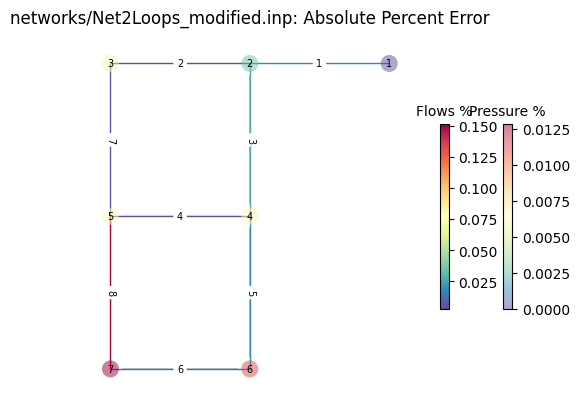

<Axes: title={'center': 'networks/Net2Loops_modified.inp: Absolute Percent Error'}>

In [20]:

wntr.graphics.plot_network(
    wn,
    node_attribute=get_ape_from_pd_series(
        results_vqls.node["pressure"].iloc[0],
        results_epanet.node["pressure"].iloc[0]
    ),
    link_attribute=get_ape_from_pd_series(
        results_vqls.link["flowrate"].iloc[0],
        results_epanet.link["flowrate"].iloc[0],
    ),
    node_colorbar_label='Pressure %',
    link_colorbar_label='Flows %',
    node_size=150,
    title=f"{inp_file}: Absolute Percent Error",
    node_labels=True,
    link_labels=True,
    node_alpha=0.5,
)

### Plot pressures and flow rates

Let's check graphically the equivalence of the results.

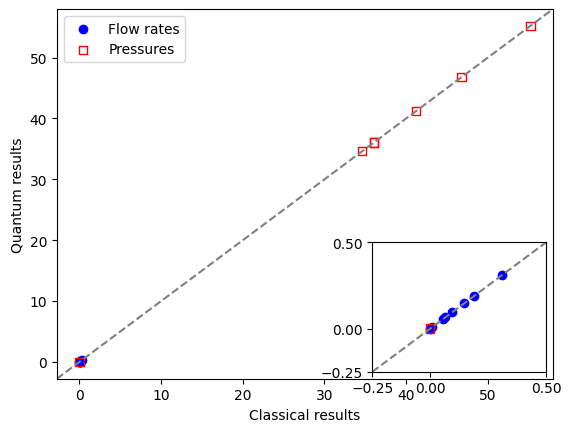

([0.31108817,
  0.09375919,
  0.18955941,
  0.00887285,
  0.14735724,
  0.055687997,
  0.065989316,
  -0.00013794545,
  55.207436,
  36.04664,
  46.78558,
  41.211903,
  34.62385,
  36.070694,
  4.3945312e-07],
 [0.31114224,
  0.09376214,
  0.18960968,
  0.008872549,
  0.1473844,
  0.05569428,
  0.06599295,
  -0.0001377366,
  55.205914,
  36.04459,
  46.7824,
  41.20937,
  34.619946,
  36.06606,
  4.3945312e-07])

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots()
ax.scatter(results_classical[:n_pipes], results_quantum[:n_pipes], label="Flow rates", color="blue", marker="o")
ax.scatter(results_classical[n_pipes:], results_quantum[n_pipes:], label="Pressures", color="red", marker="s", facecolors='none')
ax.axline((0, 0), slope=1, linestyle="--", color="gray", label="")
ax.set_xlabel("Classical results")
ax.set_ylabel("Quantum results")
ax.legend()

# inset plot
ax_inset = inset_axes(ax, width="35%", height="35%", loc="lower right")
ax_inset.scatter(results_classical[:n_pipes], results_quantum[:n_pipes], color="blue", marker="o")
ax_inset.scatter(results_classical[n_pipes:], results_quantum[n_pipes:], color="red", marker="s", facecolors='none')
ax_inset.axline((0, 0), slope=1, linestyle="--", color="gray")
ax_inset.set_xlim(-0.25, 0.5)
ax_inset.set_ylim(-0.25, 0.5)
ax_inset.set_xticks([-0.25, 0, 0.5])
ax_inset.set_yticks([-0.25, 0, 0.5])
# plt.legend()
plt.show()

results_classical, results_quantum